## importing libraries...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Embedding,TextVectorization
import re
import random
import tensorflow as tf
import tensorflow
from keras.utils import to_categorical

In [2]:
# ignore warnings....
warnings.filterwarnings("ignore")

## Manipulate Data...

In [3]:
train_df = pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

train_df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11180,14979,59931,"Forest Hill, England",20-03-2020,Is the govt preparing for rationing? Supermark...,Positive
13111,16910,61862,"Ontario, Canada",21-03-2020,Today feels like Loco Blanco! ?Tequila barrel ...,Positive
34028,37827,82779,"South End, Concord",08-04-2020,It is critical we start preparing now for what...,Extremely Positive
8619,12418,57370,United Kingdom,20-03-2020,This is not fair This nurse is faced with empt...,Positive
37351,41150,86102,NaN,10-04-2020,"DS Smith, the best #paperrecycling and #packag...",Neutral
3778,7577,52529,WOKEminster Abbey ?,18-03-2020,#BringBackBritishBrains ??\r\r\n\r\r\nOur nati...,Positive
23457,27256,72208,Gombe,26-03-2020,In times of crisis like 19 pandemic people hoa...,Positive
25142,28941,73893,Around the world ?,30-03-2020,Not all the businesses struggle during a crisi...,Extremely Negative
17622,21421,66373,NaN,23-03-2020,The great toilet tissue scare tees for sale | ...,Positive
14640,18439,63391,NaN,21-03-2020,Just left a grocery store. Who knew it only to...,Extremely Positive


In [4]:
# cheking the shape of data....
print(f"Train data-set has {train_df.shape[0]} rows and {train_df.shape[1]} columns \n")
print(f"Test data-set has {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Train data-set has 41157 rows and 6 columns 

Test data-set has 3798 rows and 6 columns


In [5]:
# checking the dtypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [7]:
# checking null values...
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
# checking the label proportion around the data...
labels_prop = train_df["Sentiment"].value_counts()
labels_prop

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

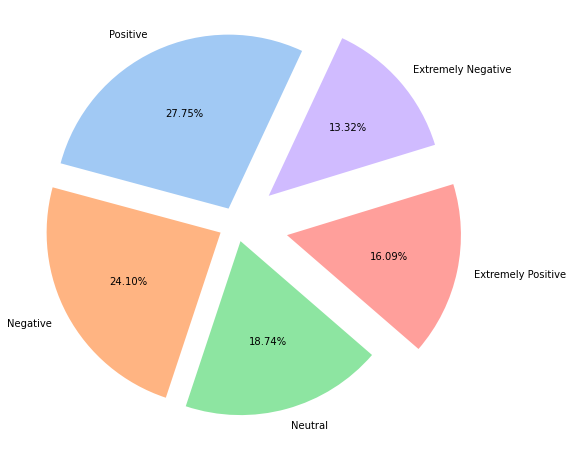

In [9]:
# let's visualize it...
labels = labels_prop.index
colors = sns.color_palette('pastel') # pastel colors
plt.figure(figsize=(10,8))
plt.pie(labels_prop,labels=labels,colors=colors,explode=[0.1,0.1,0.1,0.3,0.25],startangle=65,autopct="%0.2f%%");

In [10]:
# let's visualize the location....
location_prop = train_df["Location"].value_counts()
location_prop

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

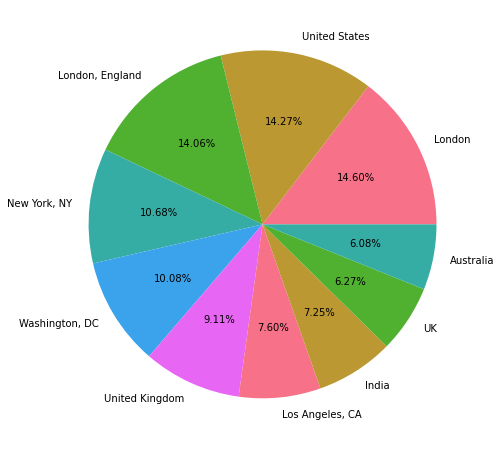

In [11]:
#  just visualize the top 10 location of the data....
labels = location_prop.index[:10]
colors = sns.color_palette("husl")
plt.figure(figsize=(10,8))
plt.pie(location_prop[:10],labels=labels,colors=colors,autopct="%.2f%%",);

In [12]:
# calculate the tweet length
train_df["Length"] = train_df["OriginalTweet"].apply(len)
train_df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
506,4305,49257,"Washington, DC",16-03-2020,NEW: Coronavirus package hits roadblocks amid ...,Neutral,108
35116,38915,83867,United States,08-04-2020,Comix Hand Sanitizer Gel 16 Fl Oz /480ml Alcoh...,Extremely Positive,274
14743,18542,63494,NaN,22-03-2020,Come with us Danny we have,Neutral,26
15555,19354,64306,NaN,22-03-2020,This isnÂt hard. Any big company that needs s...,Positive,260
12780,16579,61531,"Ipswich, England",21-03-2020,@CashApp I work in a supermarket and IÂm run ...,Neutral,247
30026,33825,78777,"New York, NY",06-04-2020,It's not just the bread baking. Here are 5 con...,Neutral,149
12793,16592,61544,"Miami, Florida",21-03-2020,Just left the supermarket It was such a gut wr...,Extremely Negative,251
17532,21331,66283,"Asheville, NC",23-03-2020,Seriously We need a thousand times over to pay...,Negative,230
28140,31939,76891,"Pretoria, South Africa",04-04-2020,Plesse take care of poor hawkers daily wagers ...,Extremely Positive,201
14858,18657,63609,NaN,22-03-2020,So very day I go to the supermarket is the sam...,Extremely Negative,213


<Figure size 720x720 with 0 Axes>

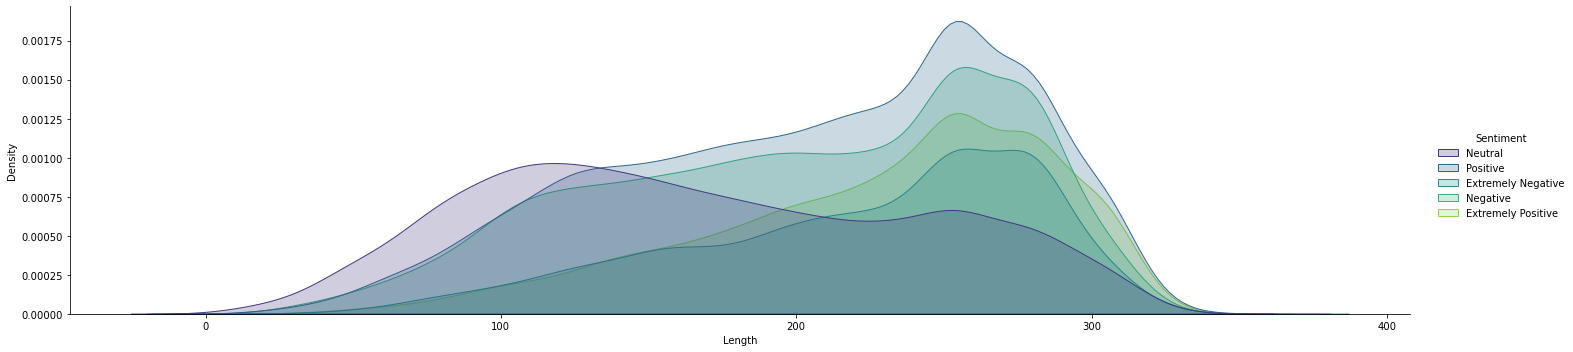

In [13]:
# visualize the tweet length accross the data-set...
plt.figure(figsize=(10,10))
sns.displot(data=train_df,x="Length",hue="Sentiment",
                 kind = 'kde', fill = True,  aspect =4 , palette = "viridis");


In [14]:
# changing the tweet text dtype
train_df["OriginalTweet"] = train_df["OriginalTweet"].astype("string")

In [15]:
train_df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    string
Sentiment        object
Length            int64
dtype: object

In [16]:
# changing the datetime dtype ...
train_df["TweetAt"] = pd.to_datetime(train_df["TweetAt"],format="%d-%m-%Y")
train_df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,237
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,131
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,306
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310


In [17]:
train_df["TweetAt"].min()

Timestamp('2020-03-16 00:00:00')

In [18]:
train_df["TweetAt"].max()

Timestamp('2020-04-14 00:00:00')

In [19]:
# checking the tweets per day
tweet_per_day  = train_df.groupby(train_df["TweetAt"]).count()["Sentiment"]
tweet_per_day = tweet_per_day.reset_index()
tweet_per_day

,TweetAt,Sentiment
0,2020-03-16,656
1,2020-03-17,1977
2,2020-03-18,2742
3,2020-03-19,3215
4,2020-03-20,3448
5,2020-03-21,2653
6,2020-03-22,2114
7,2020-03-23,2062
8,2020-03-24,1480
9,2020-03-25,2979


In [20]:
tweet_per_day["Month"] = tweet_per_day["TweetAt"].apply(lambda x : x.month)
tweet_per_day

,TweetAt,Sentiment,Month
0,2020-03-16,656,3
1,2020-03-17,1977,3
2,2020-03-18,2742,3
3,2020-03-19,3215,3
4,2020-03-20,3448,3
5,2020-03-21,2653,3
6,2020-03-22,2114,3
7,2020-03-23,2062,3
8,2020-03-24,1480,3
9,2020-03-25,2979,3


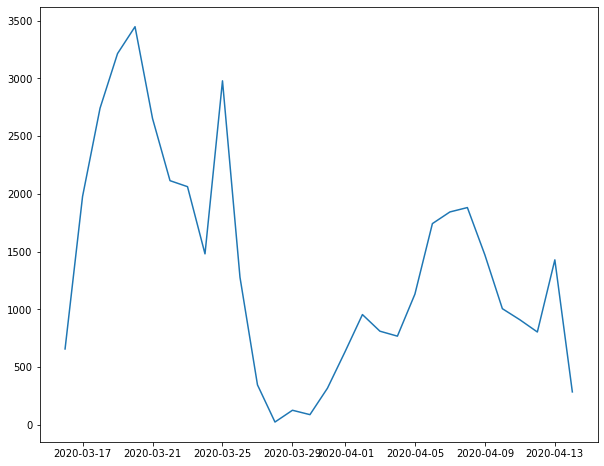

In [21]:
# let's visualize tweet per day..
plt.figure(figsize=(10,8))
plt.plot(tweet_per_day["TweetAt"],tweet_per_day["Sentiment"]);

In [22]:
train_df["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

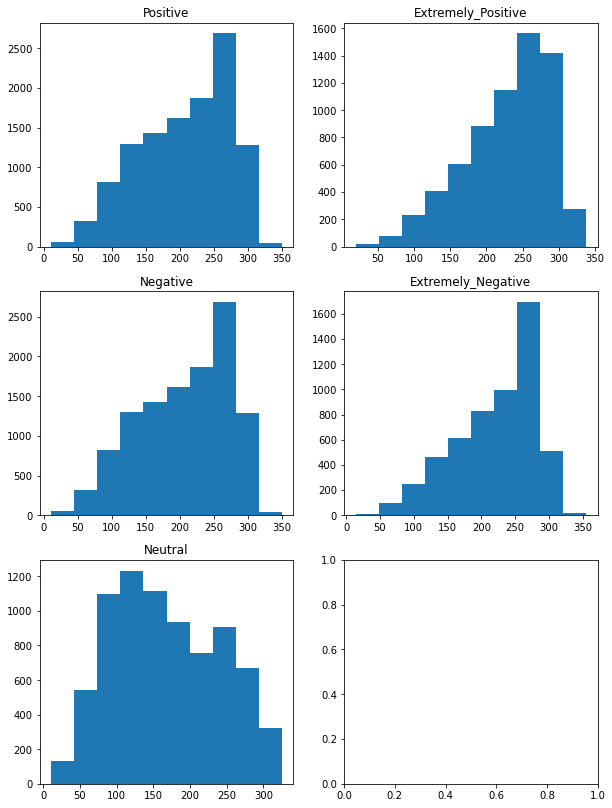

In [23]:
# plotting the number of characters per sentiment
len_neutral = train_df[train_df["Sentiment"]=="Neutral"]["OriginalTweet"].str.len()

# positive sentiment 
len_positive = train_df[train_df["Sentiment"]=="Positive"]["OriginalTweet"].str.len()

# negative sentiment 
len_negative = train_df[train_df["Sentiment"]=="Positive"]["OriginalTweet"].str.len()

# extremely negative 
len_ex_neg = train_df[train_df["Sentiment"]=="Extremely Negative"]["OriginalTweet"].str.len()

# extremely positive
len_ex_pos = train_df[train_df["Sentiment"]=="Extremely Positive"]["OriginalTweet"].str.len()

# let's plot the len of characters in each sentiment category....
# plt.figure(figsize=(10,8))
figure,ax = plt.subplots(3,2,figsize=(10,14))
ax[0,0].hist(len_positive)
ax[0,0].set_title("Positive")

ax[0,1].hist(len_ex_pos)
ax[0,1].set_title("Extremely_Positive")

ax[1,0].hist(len_negative)
ax[1,0].set_title("Negative")

ax[1,1].hist(len_ex_neg)
ax[1,1].set_title("Extremely_Negative")

ax[2,0].hist(len_neutral)
ax[2,0].set_title("Neutral")

plt.show()

In [24]:
train_df[train_df["Sentiment"]== "Positive"]["Length"]

1        237
2        131
3        306
5        250
6        180
        ... 
41140    302
41145    105
41146    290
41150    199
41154    136
Name: Length, Length: 11422, dtype: int64

In [25]:
# change the sentiment type

def change_sen(sentiment):
    if sentiment == "Positive":
        return "positive"
    elif sentiment == "Extremely Positive":
        return "positive"
    elif sentiment == "Negative":
        return "negative"
    elif sentiment == "Extremely Negative":
        return "negative"
    else:
        return "neutral"

In [26]:
train_df["Sentiment"] = train_df["Sentiment"].apply(change_sen)
test_df["Sentiment"] = test_df["Sentiment"].apply(change_sen)

# let's check the changes
train_df["Sentiment"].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

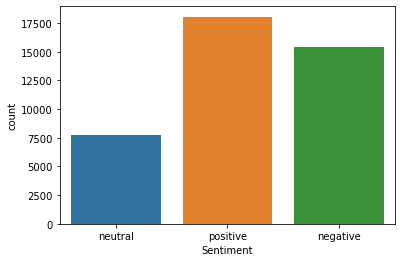

In [27]:
# plot it
sns.countplot(train_df["Sentiment"]);

In [28]:
# as our label is in text so map it

l = {"neutral" : 0, "positive" : 1,"negative" : 2}

# apply it to the data....

train_df["Sentiment"] = train_df["Sentiment"].map(l)
test_df["Sentiment"] = test_df["Sentiment"].map(l)

In [29]:
# train_df["Sentiment"] = to_categorical(train_df["Sentiment"],3)
# test_df["Sentiment"] = to_categorical(test_df["Sentiment"],3)

In [30]:
train_df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
25591,29390,74342,Berlin/Germany,2020-04-01,The economic impacts of the COVID 19 pandemic ...,1,240
21685,25484,70436,LAGOS-ABUJA-IBADAN-PH,2020-03-25,In a bit to still communicate valuable informa...,1,279
31213,35012,79964,Ottawa,2020-04-06,Shared an older version of this chart about th...,1,239
30439,34238,79190,Bikeville,2020-04-06,@anneramsey740 Every single grocery store surr...,2,155
38207,42006,86958,NaN,2020-04-11,On March 20 Gov DeSantis closed restaurant din...,1,261
26208,30007,74959,"Torbay, England",2020-04-02,A second has been planed for tonight at 8pm ...,1,121
15346,19145,64097,"Bury, England",2020-03-22,I see once again the Great British public are ...,1,220
20706,24505,69457,NaN,2020-03-25,Support food banks don t panic buy and be resp...,1,53
30928,34727,79679,NaN,2020-04-06,My husbands sister got mad at me for telling h...,2,277
27220,31019,75971,Downtown LA,2020-04-03,"""LA rental prices fall for the first time in a...",0,124


In [31]:
train_df["Sentiment"].unique()

array([0, 1, 2])

In [32]:
# split the data into train and test set by picking only main columns
X_train = train_df["OriginalTweet"]
y_train = train_df["Sentiment"]

X_test = test_df["OriginalTweet"]
y_test = test_df["Sentiment"]

# checking the sets...
len(X_train),len(y_train),len(X_test),len(y_test)

(41157, 41157, 3798, 3798)

In [33]:
# let's make a function that will evaluate our model performance....
def calculate_results(y_true,y_pred):
    """
    This function will evaluate our model performace by measuring certain metrics....
    Accuracy : it tells us that how accurately our model predict the label
    Precision : this is the ability of classifier not to label a negative label as positive.
    Recall : this is the ability of classifier to find all positive labels.
    Fscore : this is the average of preicision and recall.
    """
    accuracy = accuracy_score(y_true,y_pred)
    precision_score,recall_score,f_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    
    results = {
        "Accuracy" : accuracy ,
        "Precision" : precision_score,
        "Recall" : recall_score,
        "F_Score" : f_score
    }
    return results

In [34]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [35]:
# as our data is in text form so let's first clean it....
# re.sub() --> return the sub-string with replace value

def clean(text):
    
#     remove punctuation marks...
    text = re.sub(r"[^\w\s]","",text)
    
#     remove URL's
    text = re.sub(r'http\S+',"",text)
    
#     remove digits
    text = re.sub(r'\d+',"",text)
    
#     remove HTML tags
    text = re.sub(r"<[^>]*>","",text)
    
#     remove mentions
    text = re.sub(r"@\w+","",text)
    
#     remove hash-tag only #
    text = re.sub(r"#","",text)
    
    return text

In [36]:
# let's apply it to the data....
X_train = X_train.apply(lambda x : clean(x))
X_test = X_test.apply(lambda x : clean(x))


X_train

0                  MeNyrbie Phil_Gahan Chrisitv  and  and 
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia Woolworths to give elder...
3        My food stock is not the only one which is emp...
4        Me ready to go at supermarket during the COVID...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when KameronWilds ...
41155    Is it wrong that the smell of hand sanitizer i...
41156    TartiiCat Well newused Rift S are going for  o...
Name: OriginalTweet, Length: 41157, dtype: object

## Tokenization


As we clean our text let's split the data and convert each split into integer through tokenization because our 
deep learning models works only with the numbers....


In [37]:
# find the average legth of sentence
np.round(sum([len(i.split()) for i in X_train])/len(X_train))

29.0

In [38]:
# find the shortest tweet
np.min([len(i.split()) for i in X_train])

0

In [39]:
# longest tweet
np.max([len(i.split()) for i in X_test])

62

In [40]:
# set the vocabulary and max length for each tweet
max_vocab_len = 15000
max_len = 35

In [41]:
token = TextVectorization(max_tokens=max_vocab_len,
                         output_sequence_length=max_len,
                         output_mode="int",
                         standardize="lower_and_strip_punctuation")

Metal device set to: Apple M1


2022-09-15 20:52:38.605109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-15 20:52:38.605187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
# let's adapt it to the text...
token.adapt(X_train)

2022-09-15 20:52:38.645500: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-15 20:52:38.683576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [43]:
# get the text information....
vocab = token.get_vocabulary()
print(f"Most common 5 words in the text : \n\n{vocab[:5]}\n")
print(f"Most least common 5 words in the text : \n\n{vocab[-5:]}")

Most common 5 words in the text : 

['', '[UNK]', 'the', 'to', 'and']

Most least common 5 words in the text : 

['grams', 'gramnow', 'grades', 'grader', 'gra']


In [44]:
# let's take a sample from text and tokenize it...
random_text = random.choice(X_train)

print(f"Original Text : \n\n{random_text}")
print(f"\nTokize Version : \n\n{token([random_text])}")

Original Text : 

Covid got these gas prices looking like  LMAO 

Tokize Version : 

[[   5  210  103  218   17  353   70 4831    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


## Embeddings:

As we've tokenized our data, let's embedd it which is the richer representation of the data.

In [45]:
embedd = Embedding(input_dim = max_vocab_len,
                  output_dim = 128,
                   input_length = max_len,
                   embeddings_initializer='uniform',
                  )

In [46]:
# let's take a sample from text, tokenize and embedd it...
random_text = random.choice(X_train)

print(f"Original Text : \n\n{random_text}")
print(f"\nTokize Version : \n\n{token([random_text])}")
print(f"\nEmbedd Version : \n\n{embedd(token([random_text]))}")

Original Text : 





              

Tokize Version : 

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Embedd Version : 

[[[ 0.03740439 -0.01105677  0.01433219 ...  0.04686684 -0.02475356
   -0.00949218]
  [ 0.03740439 -0.01105677  0.01433219 ...  0.04686684 -0.02475356
   -0.00949218]
  [ 0.03740439 -0.01105677  0.01433219 ...  0.04686684 -0.02475356
   -0.00949218]
  ...
  [ 0.03740439 -0.01105677  0.01433219 ...  0.04686684 -0.02475356
   -0.00949218]
  [ 0.03740439 -0.01105677  0.01433219 ...  0.04686684 -0.02475356
   -0.00949218]
  [ 0.03740439 -0.01105677  0.01433219 ...  0.04686684 -0.02475356
   -0.00949218]]]


## Model building

    ~We'll build a series of model and pick the one that performs better.
    ~Naive Model
    ~Dense Model
    ~LSTM Model
    ~GRU Model

## Naive Model

In [47]:
# let's build the naive model
clf = Pipeline([
    ("Tfidf",TfidfVectorizer()),
    ("NB",MultinomialNB())
])

clf.fit(X_train,y_train)

Pipeline(steps=[('Tfidf', TfidfVectorizer()), ('NB', MultinomialNB())])

In [48]:
# model prediction....
model_0_pred = clf.predict(X_test)
model_0_pred[:5]

array([2, 1, 1, 2, 2])

In [49]:
# calculate model results....
model_0_results = calculate_results(y_test,model_0_pred)
model_0_results

{'Accuracy': 0.6253291205897841,
 'Precision': 0.6663493750431053,
 'Recall': 0.6253291205897841,
 'F_Score': 0.5695089252633851}

In [50]:
X_train.shape[0]

41157

## Model 1 : Dense Model

In [51]:
# previously we build scikit-learn naive model, let's build our first deep learning model...

# define the input layer.....
inputs = layers.Input(shape=(1,),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the output layer....
# adding the globalaverage layer...
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_1 = tensorflow.keras.Model(inputs,output,name="Dense_Model")

# compiling the model...
model_1.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])



In [52]:
# checking the model summary
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 35)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 35, 128)           1920000   
                                                                 
 dense (Dense)               (None, 35, 64)            8256      
                                                                 
 dense_1 (Dense)             (None, 35, 32)            2080      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                

In [53]:
X_train.shape

(41157,)

In [54]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [55]:
# fitting the model to data....
history_1 = model_1.fit(X_train,y_train,
                       epochs=10,
                       validation_data=(X_test,y_test),
                        validation_split = int(len(X_test) * 0.25),)
#                         callbacks = [tensorflow.keras.callbacks.ModelCheckpoint("Dense_1.keras",
#                                                                                save_best_only=True)])

Epoch 1/10


2022-09-15 20:52:40.968466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1287/1287 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.7002

2022-09-15 20:53:03.054875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1287/1287 [==============================] - 23s 18ms/step - loss: 0.7132 - accuracy: 0.7002 - val_loss: 0.6265 - val_accuracy: 0.7609
Epoch 2/10
1287/1287 [==============================] - 22s 17ms/step - loss: 0.5241 - accuracy: 0.8211 - val_loss: 0.6228 - val_accuracy: 0.7709
Epoch 3/10
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4825 - accuracy: 0.8410 - val_loss: 0.6046 - val_accuracy: 0.7875
Epoch 4/10
1287/1287 [==============================] - 23s 18ms/step - loss: 0.4586 - accuracy: 0.8494 - val_loss: 0.6057 - val_accuracy: 0.7794
Epoch 5/10
1287/1287 [==============================] - 23s 18ms/step - loss: 0.4433 - accuracy: 0.8552 - val_loss: 0.6247 - val_accuracy: 0.7807
Epoch 6/10
1287/1287 [==============================] - 23s 18ms/step - loss: 0.4307 - accuracy: 0.8612 - val_loss: 0.6405 - val_accuracy: 0.7775
Epoch 7/10
1287/1287 [==============================] - 22s 17ms/step - loss: 0.4204 - accuracy: 0.8656 - val_loss: 0.6373 - val_accura

In [56]:
# evaluate model performance....
model_1_pred = model_1.predict(X_test)
model_1_pred

 35/119 [=======>......................] - ETA: 0s

2022-09-15 20:56:26.172206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 1s 5ms/step


array([[2.9936793e-01, 3.9339818e-02, 6.6129220e-01],
       [7.6416386e-03, 9.9023145e-01, 2.1268653e-03],
       [7.9063009e-03, 9.8769033e-01, 4.4033574e-03],
       ...,
       [8.7008911e-01, 7.4975818e-02, 5.4935079e-02],
       [5.8151799e-04, 2.1468051e-04, 9.9920386e-01],
       [7.5785152e-05, 9.9986911e-01, 5.5032961e-05]], dtype=float32)

In [57]:
model_1_pred = tf.squeeze(tf.round(model_1_pred))
model_1_pred

<tf.Tensor: shape=(3798, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [58]:
# calculate_results
model_1_results = calculate_results(y_test,model_1_pred)
model_1_results

{'Accuracy': 0.7546076882569773,
 'Precision': 0.8017270481378187,
 'Recall': 0.7546076882569773,
 'F_Score': 0.7773954807512868}

In [59]:
# getting the history keys....
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
# let's make a funciton that will plot the model performance....
def plot_model(history):
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    epochs = range(len(loss))
    
#     plottint the model accuracy vs validation accuracy
    plt.plot(epochs,acc,label="Training Accuracy")
    plt.plot(epochs,val_acc,label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
#     plotting the training vs validation loss
    plt.figure()
    plt.plot(epochs,loss,label="Training Loss")
    plt.plot(epochs,val_loss,label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

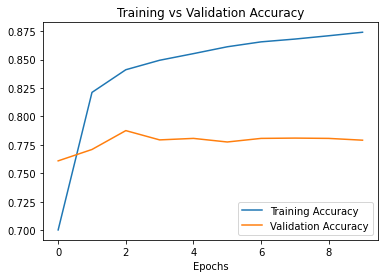

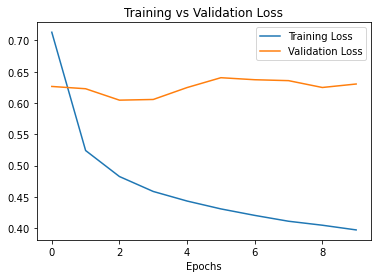

In [61]:
# plot the model performance....
plot_model(history_1)

Above plots clearly shows that our model overfits the data, so let's try some few models.

## Model 2 : LSTM

In [62]:

# define the input layer.....
inputs = layers.Input(shape=(1,),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the lstm layer
x = layers.LSTM(64,return_sequences=True)(x)
x = layers.LSTM(32,)(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_2 = tensorflow.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_2.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [63]:
# checkout the model 2 summary
model_2.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 35)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 35, 128)           1920000   
                                                                 
 dense_3 (Dense)             (None, 35, 64)            8256      
                                                                 
 dense_4 (Dense)             (None, 35, 32)            2080      
                                                                 
 lstm (LSTM)                 (None, 35, 64)            24832     
                                                        

In [64]:
# fitting the model to data....
history_2 = model_2.fit(X_train,y_train,
                       epochs=15,
                       validation_data=(X_test,y_test),
                        validation_split = int(len(X_test) * 0.25),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/15


2022-09-15 20:56:28.537233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 20:56:28.793396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 20:56:28.889265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 20:56:28.984952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 20:56:29.131897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1287/1287 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8555

2022-09-15 20:57:12.149450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 20:57:12.256687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 20:57:12.330807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1287/1287 [==============================] - 47s 35ms/step - loss: 0.4119 - accuracy: 0.8555 - val_loss: 0.5828 - val_accuracy: 0.7928
Epoch 2/15
1287/1287 [==============================] - 45s 35ms/step - loss: 0.3477 - accuracy: 0.8813 - val_loss: 0.5434 - val_accuracy: 0.8004
Epoch 3/15
1287/1287 [==============================] - 44s 34ms/step - loss: 0.3234 - accuracy: 0.8900 - val_loss: 0.6154 - val_accuracy: 0.7780
Epoch 4/15
1287/1287 [==============================] - 44s 34ms/step - loss: 0.3059 - accuracy: 0.8969 - val_loss: 0.6042 - val_accuracy: 0.7952
Epoch 5/15
1287/1287 [==============================] - 45s 35ms/step - loss: 0.2908 - accuracy: 0.9014 - val_loss: 0.6048 - val_accuracy: 0.7809


In [65]:
# make prediction and calculate results....
model_2_results = calculate_results(y_test,tf.squeeze(tf.round(model_2.predict(X_test))))
model_2_results

2022-09-15 21:00:12.877246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:00:12.974776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:00:13.050107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 2s 13ms/step


{'Accuracy': 0.7648762506582412,
 'Precision': 0.8152356006246738,
 'Recall': 0.7648762506582412,
 'F_Score': 0.7781460541005929}

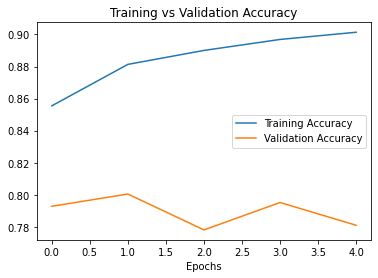

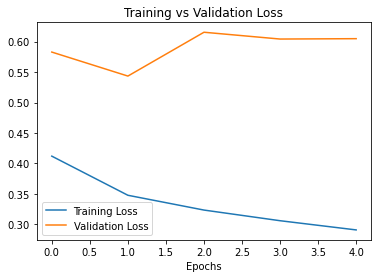

In [66]:
# plot the model performance....
plot_model(history_2)

## Model 3 : GRU

In [67]:

# define the input layer.....
inputs = layers.Input(shape=(1,),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(128,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(64,activation="relu")(x)
# adding the GRU layer....
x = layers.GRU(64,return_sequences=True)(x)
x = layers.GRU(32,)(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_3 = tensorflow.keras.Model(inputs,output,name="GRU")

# compiling the model...
model_3.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [68]:
# summary of the model...
model_3.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 35)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 35, 128)           1920000   
                                                                 
 dense_6 (Dense)             (None, 35, 128)           16512     
                                                                 
 dense_7 (Dense)             (None, 35, 64)            8256      
                                                                 
 gru (GRU)                   (None, 35, 64)            24960     
                                                               

In [69]:
# fitting the model to data....
history_3 = model_3.fit(X_train,y_train,
                       epochs=10,
                       validation_data=(X_test,y_test),
                        validation_split = int(len(X_test) * 0.25),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10


2022-09-15 21:00:16.629242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:00:16.915638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:00:17.005052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:00:17.179144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:00:17.343764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1287/1287 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8065

2022-09-15 21:01:05.692814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:01:05.800511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:01:05.876752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1287/1287 [==============================] - 53s 39ms/step - loss: 0.5112 - accuracy: 0.8065 - val_loss: 0.6558 - val_accuracy: 0.7496
Epoch 2/10
1287/1287 [==============================] - 47s 36ms/step - loss: 0.7135 - accuracy: 0.6987 - val_loss: 1.1604 - val_accuracy: 0.4821
Epoch 3/10
1287/1287 [==============================] - 47s 36ms/step - loss: 0.7604 - accuracy: 0.6742 - val_loss: 0.9932 - val_accuracy: 0.5329
Epoch 4/10
1287/1287 [==============================] - 48s 37ms/step - loss: 0.7624 - accuracy: 0.6723 - val_loss: 0.9061 - val_accuracy: 0.6022


In [70]:
# make prediction and calculate results....
model_3_results = calculate_results(y_test,tf.squeeze(tf.round(model_3.predict(X_test))))
model_3_results

2022-09-15 21:03:30.036830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:03:30.135460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:03:30.212422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 2s 14ms/step


{'Accuracy': 0.5431806213796735,
 'Precision': 0.6419601338183852,
 'Recall': 0.5431806213796735,
 'F_Score': 0.5597809457231571}

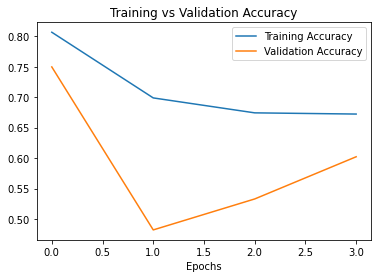

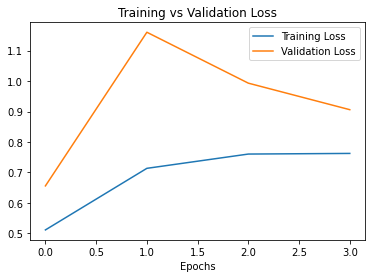

In [71]:
# plot the model performance....
plot_model(history_3)

In [72]:
# compare the model results...
model_results = pd.DataFrame({
    "Naive_results" : model_0_results,
    "Dense_results" : model_1_results,
    "LSTM_results" : model_2_results,
    "GRU_results" : model_3_results,
})
model_results

,Naive_results,Dense_results,LSTM_results,GRU_results
Accuracy,0.625329,0.754608,0.764876,0.543181
Precision,0.666349,0.801727,0.815236,0.641960
Recall,0.625329,0.754608,0.764876,0.543181
F_Score,0.569509,0.777395,0.778146,0.559781


In [73]:
model_results = model_results.transpose()
model_results

,Accuracy,Precision,Recall,F_Score
Naive_results,0.625329,0.666349,0.625329,0.569509
Dense_results,0.754608,0.801727,0.754608,0.777395
LSTM_results,0.764876,0.815236,0.764876,0.778146
GRU_results,0.543181,0.641960,0.543181,0.559781


<AxesSubplot:>

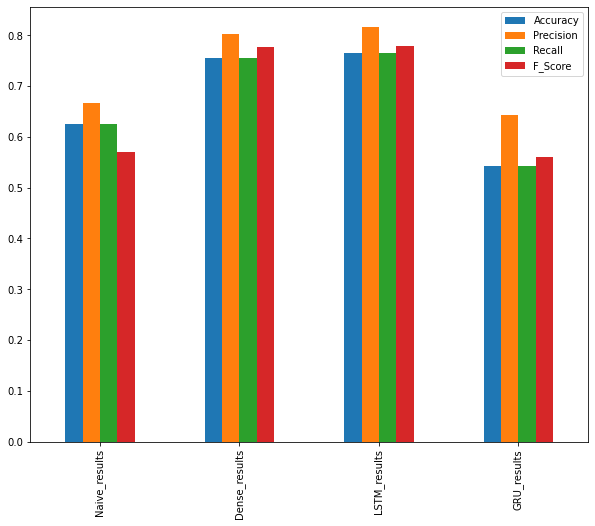

In [74]:
# let's visualize it....
model_results.plot(kind="bar",figsize=(10,8))

# As our 3rd model (LSTM) performs better than others so pick it to make it better.

## Preprocessing words as a Set : The bag of words approach...

In [75]:
# tokenization 
text_vectorization = TextVectorization(max_tokens=max_vocab_len,
                                      standardize="lower_and_strip_punctuation",
                                      output_mode="multi_hot",
                                      split= "whitespace",)

# adapt text_vectorization to data...
text_vectorization.adapt(X_train)
# Embeddings.....
embedding = Embedding(input_dim = max_vocab_len,
                     output_dim=128,
                     input_length=max_len,
                     )

# building the model

# define the input layer.....
inputs = layers.Input(shape=(1,),dtype="string")
# pass the input layer to tokenization....
x = text_vectorization(inputs)
# pass the token into embedd layer.....
x = embedding(x)

# hidden layer.....
x = layers.Dense(128,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(64,activation="relu")(x)
# adding the 3rd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the lstm layer
x = layers.LSTM(128,return_sequences=True)(x)
x = layers.LSTM(64,return_sequences=True)(x)
x = layers.LSTM(32,)(x)

# output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_4 = tensorflow.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_4.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

2022-09-15 21:03:32.224381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [76]:
# check out the model summary
model_4.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15000)            0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15000, 128)        1920000   
                                                                 
 dense_9 (Dense)             (None, 15000, 128)        16512     
                                                                 
 dense_10 (Dense)            (None, 15000, 64)         8256      
                                                                 
 dense_11 (Dense)            (None, 15000, 32)         2080      
                                                        

In [ ]:
# fitting the model to data....
history_4 = model_4.fit(X_train,y_train,
                       epochs=10,
                       validation_data=(X_test,y_test),
                        validation_split = int(len(X_test) * 0.25),
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10


2022-09-15 21:03:35.687988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-15 21:03:36.390913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
